In [1]:
import gym

#from my_lunar_lander import LunarLander
#env = LunarLander()
env = gym.make("LunarLander-v2")

C:\Users\giuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Understand the environment

In [2]:
def show_action_and_env_space(env):
    # Action space and environment space
    print("env.action_space", env.action_space)
    print("env.observation_space", env.observation_space)
    print("env.observation_space.high", env.observation_space.high)
    print("env.observation_space.low", env.observation_space.low)
show_action_and_env_space(env)

env.action_space Discrete(4)
env.observation_space Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
env.observation_space.high [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
env.observation_space.low [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]


### Utility functions for SARSA and Q-Learning

In [4]:
# Discretizzazione naive
n = 5

s_space = np.linspace(-1.5, 1.5, n) # min max n_parti
v_space = np.linspace(5, 5, n)
theta_space = np.linspace(-3.1415927, 3.1415927, n)
omega_space = np.linspace(5, 5, n)

def discretize_states(observation):
    sx, sy, vx, vy, theta, omega, bo1, bo2 = observation
    sx_d = int(np.digitize(sx, s_space))
    sy_d = int(np.digitize(sy, s_space))
    vx_d = int(np.digitize(vx, v_space))
    vy_d = int(np.digitize(vy, v_space))
    theta_d = int(np.digitize(theta, theta_space))
    omega_d = int(np.digitize(omega, omega_space))

    return (sx_d, sy_d, vx_d, vy_d, theta_d, omega_d, bo1, bo2)   

In [5]:
def discretize(n, obs):
    tu = [min(np.floor(n/2), max(-np.floor(n/2), int(x/0.05))) for x in obs]
    return tuple(tu)

In [7]:
states = []
for sx in range(10+1):
    for sy in range(10+1):
        for vx in range(10+1):
            for vy in range(10+1):
                for theta in range(n+1):
                    for omega in range(n+1):
                        for bo1 in range(2):
                            for bo2 in range(2):
                                states.append((sx, sy, vx, vy, theta, omega, bo1, bo2))
state_number = len(states)

actions = [0,1,2,3]
action_number = len(actions)


In [8]:
def init_Qtable(state_number, action_number):
    q_table = {}
    for state in states:
        for action in actions:
            q_table[state,action] = 0
    return q_table

In [1]:
import models
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.01
eps = 0.1
gamma = 0.99
episodes = 1000

rew_r = models.random_agent(episodes)
rew_s = models.sarsa(alpha, gamma, episodes)
rew_q = models.q_learning(alpha, gamma, episodes)

C:\Users\giuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


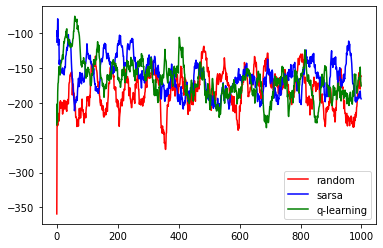

In [2]:
mean_rewards_r = np.zeros(episodes)
mean_rewards_s = np.zeros(episodes)
mean_rewards_q = np.zeros(episodes)
for t in range(episodes):
    mean_rewards_r[t] = np.mean(rew_r[max(0, t-20):(t+1)])
    mean_rewards_s[t] = np.mean(rew_s[max(0, t-20):(t+1)])
    mean_rewards_q[t] = np.mean(rew_q[max(0, t-20):(t+1)])

plt.plot(mean_rewards_r, color="red", label="random")
plt.plot(mean_rewards_s, color="blue", label="sarsa")
plt.plot(mean_rewards_q, color="green", label="q-learning")
plt.legend()
plt.show()